## Restricted Botlzman Machines (RBM)

In [1]:
#FIXME: Review the generation process (theoretically) and fix the implementation 

In [2]:
import os
from typing import List, Dict, Tuple, Literal, Optional, Union, Iterable

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
from tqdm import tqdm
from numpy._typing import ArrayLike

ArrayLike = Union[List, Tuple, np.ndarray]

In [3]:
DATA_FOLDER = "../data/"
ALPHA_DIGIT_PATH = os.path.join(DATA_FOLDER, "binaryalphadigs.mat")
MNIST_PATH = os.path.join(DATA_FOLDER, "mnist_all.mat")

if not os.path.exists(ALPHA_DIGIT_PATH):
    raise FileNotFoundError(f"The file {ALPHA_DIGIT_PATH} does not exist.")

### 3.1 Implementing a RBM and testing on Binary AlphaDigits

In [4]:
def _load_data(file_path: str) -> Dict[str, np.ndarray]:
    """
    Load Binary AlphaDigits data from a .mat file.

    Parameters:
    - file_path (str): Path to the .mat file containing the data.

    Returns:
    - data (dict): Loaded data dictionary.
    """
    if file_path is None:
        raise ValueError("File path must be provided.")

    return scipy.io.loadmat(file_path)


data = _load_data(ALPHA_DIGIT_PATH)
class_labels = data["classlabels"].flatten() 
class_count = data["classcounts"].flatten()
df = pd.DataFrame(
    {
        "Class Labels": class_labels,
        "Class Count": class_count
    }
)
df["Class Labels"] = df["Class Labels"].apply(lambda x: x[0])
df["Class Count"] = df["Class Count"].apply(lambda x: x[0][0])
df

,Class Labels,Class Count
0,0,39
1,1,39
2,2,39
3,3,39
4,4,39
5,5,39
6,6,39
7,7,39
8,8,39
9,9,39


In [5]:
def _load_data(file_path: str, which: Literal["alphadigit", "mnist"]="alphadigit") -> Dict[str, np.ndarray]:
    """
    Load Binary AlphaDigits data from a .mat file.

    Parameters:
    - file_path (str): Path to the .mat file containing the data.
    - which (Literal["alphadigit", "mnist"], optional): Specifies 
        which data to load. The default value is "alphadigit".

    Returns:
    - data (dict): A dictionary containing the loaded data.

    Raises:
    - ValueError: If the file_path parameter is None.
    - ValueError: If the which parameter is not "alphadigit".

    Example Usage:
    ```python
    data = _load_data("data.mat", "alphadigit")
    ```
    """
    if file_path is None:
        raise ValueError("File path must be provided.")
    
    if which == "alphadigit":
        return scipy.io.loadmat(file_path)["dat"]
    
    raise ValueError("MNIST NOT YET AVAILABLE.")

alphadigit_data = _load_data(ALPHA_DIGIT_PATH) 
print(alphadigit_data.shape)
print(alphadigit_data[0][0].shape)

(36, 39)
(20, 16)


In [6]:
def _map_characters_to_indices(characters: Union[str, int, List[Union[str, int]]]) -> List[int]:
    """
    Map alphanumeric character to its corresponding index.

    Parameters:
    - character (str, int, list of str or int): Alphanumeric character or its index.

    Returns:
    - char_index (int): Corresponding index for the character.
    """
    if isinstance(characters, list):
        return [_map_characters_to_indices(char) for char in characters]
    if isinstance(characters, int) and 0 <= characters <= 35:
        return [characters]
    if (isinstance(characters, str) and characters.isdigit()
          and 0 <= int(characters) <= 9):
        return [int(characters)]
    if (isinstance(characters, str) and characters.isalpha()
          and 'A' <= characters.upper() <= 'Z'):
        return [ord(characters.upper()) - ord('A') + 10]
    
    raise ValueError(
        "Invalid character input. It should be an alphanumeric" 
        "character '[0-9|A-Z]' or its index representing '[0-35]'."
    )

for char in [0, 10, "A", [1, "C"], 36]:
    try:
        map = _map_characters_to_indices(char)
        print(f"{char} > map to > {map}")
    except:
        print(f"{char} > no mapping available, out of range")

0 > map to > [0]
10 > map to > [10]
A > map to > [10]
[1, 'C'] > map to > [[1], [12]]
36 > no mapping available, out of range


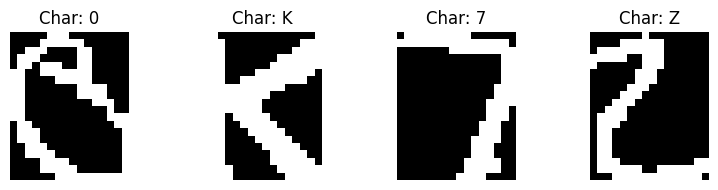

In [7]:
def read_alpha_digit(characters: Optional[Union[str, int, List[Union[str, int]]]] = None,
                     file_path: Optional[str] = ALPHA_DIGIT_PATH,
                     data: Optional[Dict[str, np.ndarray]] = None,
                     use_data: bool = False,
                     ) -> np.ndarray:
    """
    Reads binary AlphaDigits data from a .mat file or uses already loaded data. 
    It extracts the data for a specified alphanumeric character or its index, and 
    flattens the images into one-dimensional vectors.

    Parameters:
    - characters (Union[str, int, List[Union[str, int]]], optional): Alphanumeric character 
        or its index whose data needs to be extracted. It can be a single character or 
        a list of characters. Default is None.
    - file_path (str, optional): Path to the .mat file containing the data. 
        Default is None.
    - data (dict, optional): Already loaded data dictionary. 
        Default is None.
    - use_data (bool): Flag to indicate whether to use already loaded data.
        Default is False.

    Returns:
    - flattened_images (numpy.ndarray): Flattened images for the specified character(s).
    """
    if not use_data:
        data = _load_data(file_path, which="alphadigit")

    char_indices = _map_characters_to_indices(characters)

    # Select the rows corresponding to the characters indices.
    char_data: np.ndarray = data[char_indices]
    
    # Flatten each image into a one-dimensional vector.
    flattened_images = np.array([image.flatten() for image in char_data.flatten()])
    return flattened_images

def plot_characters(chars, data):
    num_chars = len(chars)
    num_images_per_char = data.shape[0] // num_chars
    fig, ax = plt.subplots(1, num_chars, figsize=(num_chars * 2, 2))

    for i, char in enumerate(chars):
        # Find the index of the first image corresponding to the current char
        start_index = i * num_images_per_char
        image = data[start_index].reshape(20, 16)
        ax[i].imshow(image, cmap='gray')
        ax[i].set_title(f'Char: {char}')
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example
chars = [0, "K", 7, "Z"]
data = read_alpha_digit(chars, data=alphadigit_data, use_data=True)
plot_characters(chars, data)

In [8]:
print("data shape:", data.shape)

data shape: (156, 320)


In [9]:
class RBM:
    def __init__(self, n_visible: int, n_hidden: int=100, random_state=None) -> None:
        """
        Initialize the Restricted Boltzmann Machine.

        Parameters:
        - n_visible (int): Number of visible units.
        - n_hidden (int): Number of hidden units. Default 100.
        - random_state: Random seed for reproducibility.
        """
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        
        self.a = np.zeros((1, n_visible))
        self.b = np.zeros((1, n_hidden))
        self.rng = np.random.default_rng(random_state)
        self.W = 1e-4 * self.rng.standard_normal(size=(n_visible, n_hidden))

    def __repr__(self) -> str:
        return f"RBM(n_visible={self.n_visible}, n_hidden={self.n_hidden})"

    def _sigmoid(self, x: np.ndarray) -> np.ndarray:
        """
        Sigmoid activation function.

        Parameters:
        - x (numpy.ndarray): Input array.

        Returns:
        - numpy.ndarray: Result of applying the sigmoid function to the input.
        """
        return 1 / (1 + np.exp(-x))
    
    def _reconstruction_error(self, input: np.ndarray, image: np.ndarray) -> float:
        """
        Compute reconstruction error.

        Parameters:
        - input (numpy.ndarray): Original input data.
        - image (numpy.ndarray): Reconstructed image.

        Returns:
        - float: Reconstruction error.
        """
        return np.round(np.power(image - input, 2).mean(), 5)

    def input_output(self, data: np.ndarray) -> np.ndarray:
        """
        Compute hidden units given visible units.

        Parameters:
        - data (numpy.ndarray): Input data, shape (n_samples, n_visible).

        Returns:
        - numpy.ndarray: Hidden unit activations, shape (n_samples, n_hidden).
        """
        return self._sigmoid(data @ self.W + self.b)

    def output_input(self, data_h: np.ndarray) -> np.ndarray:
        """
        Compute visible units given hidden units.

        Parameters:
        - data_h (numpy.ndarray): Hidden unit activations, shape (n_samples, n_hidden).

        Returns:
        - numpy.ndarray: Reconstructed visible units, shape (n_samples, n_visible).
        """
        return self._sigmoid(data_h @ self.W.T + self.a)

    def train(self, 
              data: np.ndarray,
              learning_rate: float=0.1,
              n_epochs: int=10,
              batch_size: int=10,
              print_each=10
        ) -> 'RBM':
        """
        Train the RBM using Contrastive Divergence.

        Parameters:
        - data (numpy.ndarray): Input data, shape (n_samples, n_visible).
        - learning_rate (float): Learning rate for gradient descent. Default is 0.1.
        - n_epochs (int): Number of training epochs. Default is 10.
        - batch_size (int): Size of mini-batches. Default is 10.

        Returns:
        - RBM: Trained RBM instance.
        """
        n_samples = data.shape[0]
        for epoch in range(n_epochs):
            self.rng.shuffle(data)
            for i in tqdm(range(0, n_samples, batch_size), desc=f"Epoch {epoch}"):
                batch = data[i:i+batch_size]
                pos_h_probs = self.input_output(batch)
                pos_v_probs = self.output_input(pos_h_probs)
                neg_h_probs = self.input_output(pos_v_probs)
                
                # Update weights and biases
                self.W += learning_rate * (batch.T @ pos_h_probs - pos_v_probs.T @ neg_h_probs) / batch_size
                self.b += learning_rate * (pos_h_probs.mean(axis=0) - neg_h_probs.mean(axis=0))
                self.a += learning_rate * (batch.mean(axis=0) - pos_v_probs.mean(axis=0))
                
            if epoch % print_each == 0:
                tqdm.write(
                    f"Reconstruction error: {self._reconstruction_error(batch, pos_v_probs)}.")

        return self

    def generate_image(self, n_samples: int=1, n_gibbs_steps: int=1) -> np.ndarray:
        """
        Generate samples from the RBM using Gibbs sampling.

        Parameters:
        - n_samples (int): Number of samples to generate. Default is 10.
        - n_gibbs_steps (int): Number of Gibbs sampling steps. Default is 1.

        Returns:
        - numpy.ndarray: Generated samples, shape (n_samples, n_visible).
        """
        samples = np.zeros((n_samples, self.n_visible))
        
        # Matrix of initlization value of Gibbs samples for each sample. 
        V = self.rng.binomial(1, self.rng.random(), size=n_samples*self.n_visible).reshape((n_samples, self.n_visible))
        for i in range(n_samples):
            for _ in range(n_gibbs_steps):
                h_probs = self._sigmoid(V[i] @ self.W + self.b) # vector
                h = self.rng.binomial(1, h_probs)
                v_probs = self._sigmoid(h @ self.W.T + self.a)
                v = self.rng.binomial(1, v_probs)
            samples[i] = v
        return samples

In [10]:
# Load the alpha_digit data
data = read_alpha_digit(file_path=ALPHA_DIGIT_PATH, characters=['Z'])

In [11]:
# Parameters
n_visible = data.shape[1]  # Number of visible units (size of each image)
n_hidden = 200  # Number of hidden units (hyperparameter)

# Initialize RBM
rbm = RBM(n_visible=n_visible, n_hidden=n_hidden, random_state=42)
print(rbm)

# Train RBM
rbm.train(data, learning_rate=0.1, n_epochs=500, batch_size=10)

RBM(n_visible=320, n_hidden=200)


Epoch 0: 100%|██████████| 4/4 [00:00<00:00, 666.50it/s]


Reconstruction error: 0.16569.


Epoch 10:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10: 100%|██████████| 4/4 [00:00<00:00, 571.35it/s]


Reconstruction error: 0.13308.


Epoch 20: 100%|██████████| 4/4 [00:00<00:00, 800.36it/s]


Reconstruction error: 0.11447.


Epoch 30: 100%|██████████| 4/4 [00:00<00:00, 666.24it/s]


Reconstruction error: 0.0752.


Epoch 40: 100%|██████████| 4/4 [00:00<00:00, 666.74it/s]


Reconstruction error: 0.05648.


Epoch 50: 100%|██████████| 4/4 [00:00<00:00, 444.37it/s]


Reconstruction error: 0.04929.


Epoch 60: 100%|██████████| 4/4 [00:00<00:00, 666.87it/s]


Reconstruction error: 0.04607.


Epoch 70: 100%|██████████| 4/4 [00:00<00:00, 666.40it/s]


Reconstruction error: 0.02899.


Epoch 80: 100%|██████████| 4/4 [00:00<00:00, 667.01it/s]


Reconstruction error: 0.01998.


Epoch 90: 100%|██████████| 4/4 [00:00<00:00, 667.32it/s]


Reconstruction error: 0.01886.


Epoch 100: 100%|██████████| 4/4 [00:00<00:00, 666.69it/s]


Reconstruction error: 0.01225.


Epoch 110: 100%|██████████| 4/4 [00:00<00:00, 800.36it/s]


Reconstruction error: 0.00928.


Epoch 120: 100%|██████████| 4/4 [00:00<00:00, 666.48it/s]


Reconstruction error: 0.00509.


Epoch 130: 100%|██████████| 4/4 [00:00<00:00, 667.03it/s]


Reconstruction error: 0.00601.


Epoch 140: 100%|██████████| 4/4 [00:00<00:00, 666.79it/s]


Reconstruction error: 0.00398.


Epoch 150: 100%|██████████| 4/4 [00:00<00:00, 666.56it/s]


Reconstruction error: 0.00366.


Epoch 160: 100%|██████████| 4/4 [00:00<00:00, 74.07it/s]


Reconstruction error: 0.00274.


Epoch 170: 100%|██████████| 4/4 [00:00<00:00, 571.33it/s]


Reconstruction error: 0.0018.


Epoch 180: 100%|██████████| 4/4 [00:00<00:00, 571.39it/s]


Reconstruction error: 0.00159.


Epoch 190: 100%|██████████| 4/4 [00:00<00:00, 666.79it/s]


Reconstruction error: 0.00206.


Epoch 200: 100%|██████████| 4/4 [00:00<00:00, 657.98it/s]


Reconstruction error: 0.0011.


Epoch 210: 100%|██████████| 4/4 [00:00<00:00, 800.10it/s]


Reconstruction error: 0.00116.


Epoch 220: 100%|██████████| 4/4 [00:00<00:00, 800.44it/s]


Reconstruction error: 0.00068.


Epoch 230: 100%|██████████| 4/4 [00:00<00:00, 571.28it/s]


Reconstruction error: 0.00066.


Epoch 240: 100%|██████████| 4/4 [00:00<00:00, 666.56it/s]


Reconstruction error: 0.00054.


Epoch 250: 100%|██████████| 4/4 [00:00<00:00, 800.21it/s]


Reconstruction error: 0.00059.


Epoch 260: 100%|██████████| 4/4 [00:00<00:00, 800.44it/s]


Reconstruction error: 0.00051.


Epoch 270: 100%|██████████| 4/4 [00:00<00:00, 800.02it/s]


Reconstruction error: 0.00052.


Epoch 280: 100%|██████████| 4/4 [00:00<00:00, 666.74it/s]


Reconstruction error: 0.00035.


Epoch 290: 100%|██████████| 4/4 [00:00<00:00, 800.25it/s]


Reconstruction error: 0.00035.


Epoch 300: 100%|██████████| 4/4 [00:00<00:00, 666.45it/s]


Reconstruction error: 0.00029.


Epoch 310: 100%|██████████| 4/4 [00:00<00:00, 799.87it/s]


Reconstruction error: 0.0003.


Epoch 320: 100%|██████████| 4/4 [00:00<00:00, 571.65it/s]


Reconstruction error: 0.00022.


Epoch 330: 100%|██████████| 4/4 [00:00<00:00, 799.94it/s]


Reconstruction error: 0.00025.


Epoch 340: 100%|██████████| 4/4 [00:00<00:00, 609.42it/s]


Reconstruction error: 0.00022.


Epoch 350: 100%|██████████| 4/4 [00:00<00:00, 666.87it/s]


Reconstruction error: 0.00022.


Epoch 360: 100%|██████████| 4/4 [00:00<00:00, 78.44it/s]


Reconstruction error: 0.00017.


Epoch 370: 100%|██████████| 4/4 [00:00<00:00, 800.40it/s]


Reconstruction error: 0.00017.


Epoch 380: 100%|██████████| 4/4 [00:00<00:00, 800.06it/s]


Reconstruction error: 0.0002.


Epoch 390: 100%|██████████| 4/4 [00:00<00:00, 799.87it/s]


Reconstruction error: 0.00021.


Epoch 400: 100%|██████████| 4/4 [00:00<00:00, 666.50it/s]


Reconstruction error: 0.00017.


Epoch 410: 100%|██████████| 4/4 [00:00<00:00, 800.40it/s]


Reconstruction error: 0.00011.


Epoch 420: 100%|██████████| 4/4 [00:00<00:00, 800.36it/s]


Reconstruction error: 0.00016.


Epoch 430: 100%|██████████| 4/4 [00:00<00:00, 1000.67it/s]


Reconstruction error: 0.00012.


Epoch 440: 100%|██████████| 4/4 [00:00<00:00, 800.36it/s]


Reconstruction error: 0.00012.


Epoch 450: 100%|██████████| 4/4 [00:00<00:00, 800.59it/s]


Reconstruction error: 0.00013.


Epoch 460: 100%|██████████| 4/4 [00:00<00:00, 815.34it/s]


Reconstruction error: 0.00012.


Epoch 470: 100%|██████████| 4/4 [00:00<00:00, 735.62it/s]


Reconstruction error: 0.0001.


Epoch 480: 100%|██████████| 4/4 [00:00<00:00, 1000.07it/s]


Reconstruction error: 9e-05.


Epoch 490: 100%|██████████| 4/4 [00:00<00:00, 800.21it/s]


Reconstruction error: 8e-05.


Epoch 499: 100%|██████████| 4/4 [00:00<00:00, 999.30it/s]


RBM(n_visible=320, n_hidden=200)

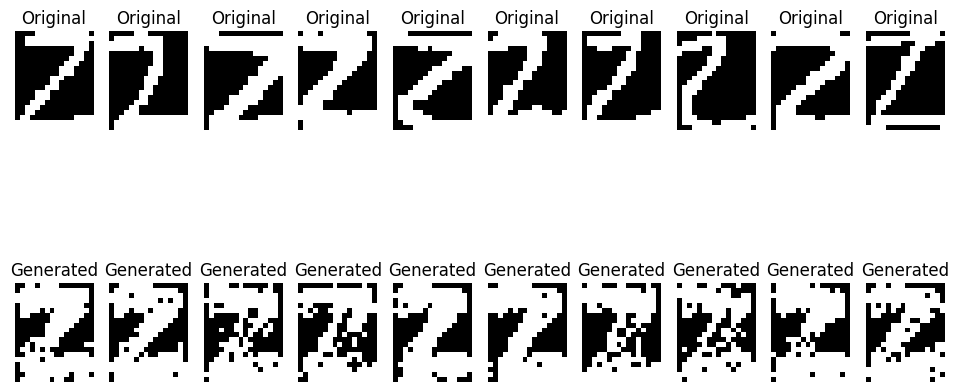

In [12]:
# Generate samples
generated_samples = rbm.generate_image(n_samples=10, n_gibbs_steps=1)

# Plot original and generated samples
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(data[i].reshape(20, 16), cmap='gray')
    plt.title('Original')
    plt.axis('off')
    
    plt.subplot(2, 10, i + 11)
    plt.imshow(generated_samples[i].reshape(20, 16), cmap='gray')
    plt.title('Generated')
    plt.axis('off')

plt.show()

In [13]:
print(rbm)

RBM(n_visible=320, n_hidden=200)


### 3.2 Implementing a Deep Belief Network (DBN) and test on Binary AlphaDigits

In [14]:
class DBN:
    def __init__(self, n_visible: int, hidden_layer_sizes: list[int], random_state=None):
        """
        Initialize the Deep Belief Network.

        Parameters:
        - n_visible (int): Number of visible units.
        - hidden_layer_sizes (list[int]): List of sizes for each hidden layer.
        - random_state: Random seed for reproducibility.
        """
        self.n_visible = n_visible
        self.hidden_layer_sizes = hidden_layer_sizes
        self.rbms: List[RBM] = []
        self.rng = np.random.default_rng(random_state)

        # Initialize the first RBM
        first_rbm = RBM(
            n_visible=n_visible,
            n_hidden=hidden_layer_sizes[0],
            random_state=random_state,
        )
        self.rbms.append(first_rbm)

        # Initialize RBMs for subsequent hidden layers
        for i, size in enumerate(hidden_layer_sizes[1:], start=1):
            rbm = RBM(
                n_visible=hidden_layer_sizes[i - 1],
                n_hidden=size,
                random_state=random_state,
            )
            self.rbms.append(rbm)


    def __getitem__(self, key):
        return self.rbms[key]
    

    def __repr__(self):
        """
        Return a string representation of the DBN object.
        """
        rbm_reprs = [repr(rbm) for rbm in self.rbms]
        join_rbm_reprs = ',\n '.join(rbm_reprs)
        return f"DBN([\n {join_rbm_reprs}\n])"


    def train(self,
        data: np.ndarray,
        learning_rate: float=0.1,
        n_epochs: int=10,
        batch_size: int=10,
        print_each: int=10,
    ) -> "DBN":
        """
        Train the DBN using Greedy layer-wise procedure.

        Parameters:
        - data (numpy.ndarray): Input data, shape (n_samples, n_visible).
        - learning_rate (float): Learning rate for gradient descent. Default is 0.1.
        - n_epochs (int): Number of training epochs. Default is 10.
        - batch_size (int): Size of mini-batches. Default is 10.
        - print_each: Print reconstruction error each `print_each` epochs.
        - verbose

        Returns:
        - DBN: Trained DBN instance.
        """
        input_data = data
        for rbm in self.rbms:
            rbm.train(
                input_data,
                learning_rate=learning_rate,
                n_epochs=n_epochs,
                batch_size=batch_size,
                print_each=print_each,
            )
            # Update input data for the next RBM
            input_data = rbm.input_output(input_data)

        return self

    def generate_image(self, n_samples: int=1, n_gibbs_steps: int=1) -> np.ndarray:
        """
        Generate samples from the DBN using Gibbs sampling.

        Parameters:
        - n_samples (int): Number of samples to generate. Default is 1.
        - n_gibbs_steps (int): Number of Gibbs sampling steps. Default is 100.

        Returns:
        - numpy.ndarray: Generated samples, shape (n_samples, n_visible).
        """
        # samples = np.zeros((n_samples, self.n_visible))

        # Generate samples using the first RBM in the DBN
        samples = self.rbms[-1].generate_image(n_samples, n_gibbs_steps)
        for rbm in reversed(self.rbms[:-1]):
            # Sample from the conditional probability of layer l-1 given layer l: p(h_{s-1}|h_{s}).
            h_probs = rbm.output_input(samples)
            h = self.rng.binomial(1, p=h_probs) 
            samples = h
        return samples

In [15]:
from principal_dbn_alpha import DBN

In [16]:
n_visible=data.shape[1]
hidden_layer_sizes = [100, 50, 25]

dbn = DBN(n_visible=n_visible, hidden_layer_sizes=hidden_layer_sizes, random_state=42)
dbn.train(data, learning_rate=0.1, n_epochs=10, batch_size=10)

Epoch 0: 100%|██████████| 4/4 [00:00<00:00, 666.48it/s]


Reconstruction error: 0.159.


Epoch 0: 100%|██████████| 4/4 [00:00<00:00, 1999.43it/s]


Reconstruction error: 0.017.


Epoch 0: 100%|██████████| 4/4 [00:00<00:00, 4004.11it/s]


Reconstruction error: 0.005.


Epoch 9: 100%|██████████| 4/4 [00:00<00:00, 4001.24it/s]


DBN([
])

In [17]:
# Check if the RBM are accessibles via a slicing 
print(dbn[1:3])

[<principal_rbm_alpha.RBM object at 0x000002AFB44D1630>, <principal_rbm_alpha.RBM object at 0x000002AFB443F8B0>]


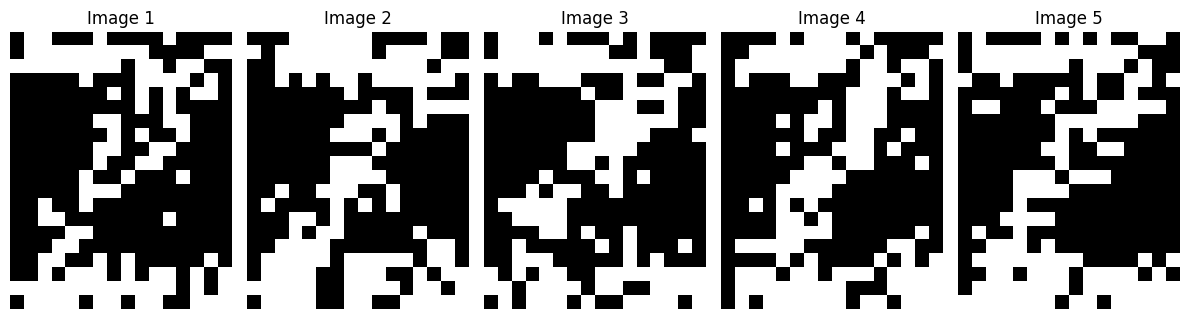

In [18]:
# # Generate images
generated_images = dbn.generate_image(n_samples=5, n_gibbs_steps=1)

# Display generated images
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 4))
for i in range(5):
    axes[i].imshow(generated_images[i].reshape(20, 16), cmap='gray')
    axes[i].set_title(f"Image {i+1}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()